In [1]:
import pandas as pd
from pathlib import Path

# Path to the directory containing the 4 scenario folders
base_path = Path("/home/haasehelen/haasehelen/ifwaste/output")  # <-- UPDATE this
EXCLUDE_COLUMNS = ['n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
    'n_quickshop', 'n_attempted_shop']

# Replace with your actual folder names if different
scenario_folders = ["scenario0_no_promotions", "scenario1_bogos_only", "scenario2_sales_only", "scenario3_both"]

# Dictionary to hold combined dataframes per scenario
scenario_data = {}

for scenario in scenario_folders:
    scenario_path = base_path / scenario
    combined_rows = []
    print(scenario_path)
    # Loop through each subfolder starting with 'run_'
    for run_folder in scenario_path.glob("run_*"):
        run_id = run_folder.name.split("_")[1]  # Extract ID from 'run_<id>'
        
        config_file = run_folder / "log_hh_config.csv"
        output_file = run_folder / "aggregated_outputs.csv"

        # Check both files exist
        if not config_file.exists() or not output_file.exists():
            print(f"Skipping {run_folder} due to missing files.")
            continue

        # Load CSVs
        try:
            df_config = pd.read_csv(config_file)
            df_output = pd.read_csv(output_file)
        except Exception as e:
            print(f"Error reading files in {run_folder}: {e}")
            continue

        # Merge on household identifier
        merge_col_candidates = list(set(df_config.columns) & set(df_output.columns))
        if not merge_col_candidates:
            print(f"No common column to merge on in {run_folder}.")
            continue
        merge_col = merge_col_candidates[0]  # Pick the common merge column

        
        merged_df = pd.merge(df_config, df_output, on=merge_col, how="inner")

        # Add unique key
        merged_df["run_household_key"] = merged_df[merge_col].apply(lambda x: f"run_{run_id}_{x}")
        merged_df = merged_df.drop(columns=EXCLUDE_COLUMNS)  
        combined_rows.append(merged_df)

    # Combine all merged rows for the scenario
    if combined_rows:
        scenario_data[scenario] = pd.concat(combined_rows, ignore_index=True)
        print(f"{scenario}: Combined {len(combined_rows)} runs.")
    else:
        print(f"{scenario}: No valid data found.")



/home/haasehelen/haasehelen/ifwaste/output/scenario0_no_promotions
scenario0_no_promotions: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario1_bogos_only
scenario1_bogos_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario2_sales_only
scenario2_sales_only: Combined 16 runs.
/home/haasehelen/haasehelen/ifwaste/output/scenario3_both
scenario3_both: Combined 16 runs.


In [2]:


food_categories = [
    'Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods', 'Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'
]

fg_names = ["FGMEAT","FGDAIRY","FGVEGETABLE","FGDRYFOOD","FGBAKED","FGSNACKS","FGSTOREPREPARED"]

lookup_df = pd.DataFrame({
    'Legend_name': food_categories,
    'Fg_name' : fg_names,
    'Servings_to_kg': [0.089, 0.146, 0.112, 0.076, 0.055, 0.071, 0.100],
    #"Color": ["#41afaa", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#af4b91"]
    "Color": ["#FFC446","#D66D10","#A40E4C","#2C2C54","#638EB5","#2F8550","#2C4A26"]
})

/scratch/local/10041665/ipykernel_3095894/458958192.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="scenario", y="Total_daily_servings", palette="Set2")
/scratch/local/10041665/ipykernel_3095894/458958192.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=mean_waste, x="scenario", y="Total_daily_servings", palette="Set2")


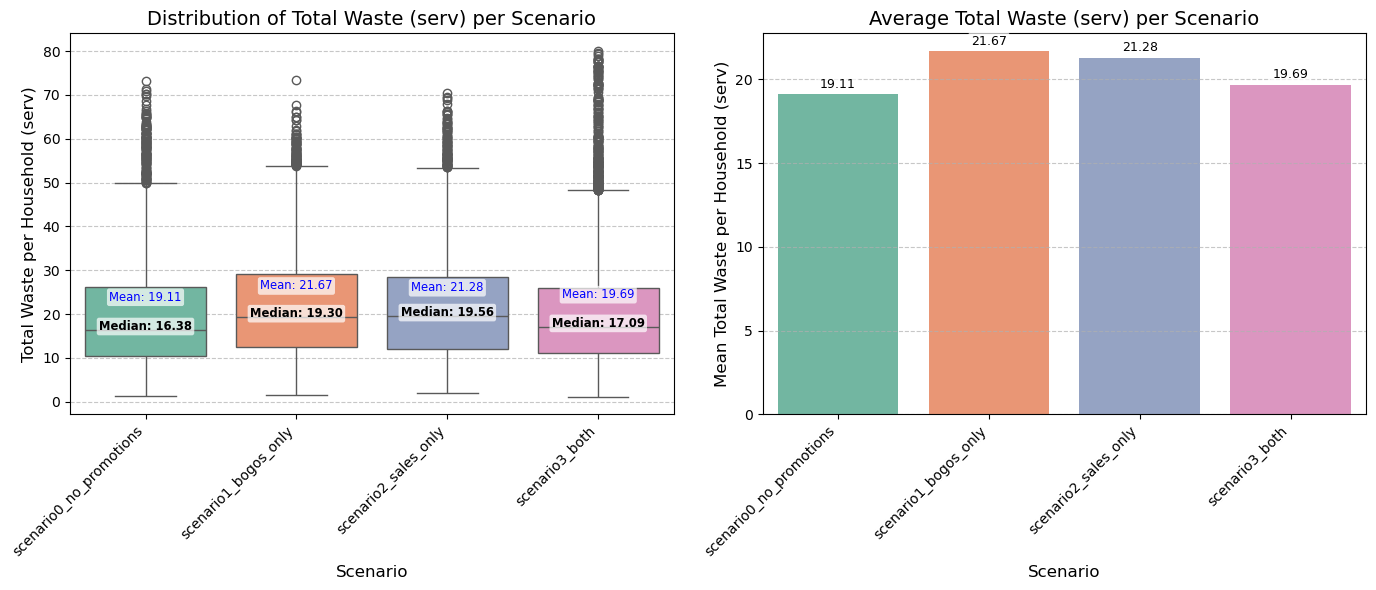

In [3]:
# Ensure these columns exist
waste_columns = ["Inedible Parts", "Plate Waste", "Spoiled Food"]
    
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

processed_scenario_dfs = []
for scenario_name, df in scenario_data.items():
    if df is not None:
        # Ensure 'Total_daily_servings' is present and calculated if not done in previous steps
        if 'Total_daily_servings' not in df.columns:
            df['Total_daily_servings'] = ((df['Inedible Parts'].fillna(0) + \
                            df['Plate Waste'].fillna(0) + \
                            df['Spoiled Food'].fillna(0)) / 100) #100 days

        df['scenario'] = scenario_name # Add scenario name as a column for seaborn plotting
        processed_scenario_dfs.append(df)
    else:
        print(f"Warning: DataFrame for scenario '{scenario_name}' is None. Skipping for plotting.")

# Combine all processed scenarios into one DataFrame for plotting
plot_df = pd.concat(processed_scenario_dfs, ignore_index=True)


plt.figure(figsize=(14, 6))

# --- Boxplot with Summary Statistics ---
plt.subplot(1, 2, 1)
sns.boxplot(data=plot_df, x="scenario", y="Total_daily_servings", palette="Set2")
plt.title("Distribution of Total Waste (serv) per Scenario", fontsize=14)
plt.xlabel("Scenario", fontsize=12)
plt.ylabel("Total Waste per Household (serv)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate summary statistics for annotations on boxplot
# We'll add Median and Mean for each box
medians = plot_df.groupby('scenario')['Total_daily_servings'].median().values
means = plot_df.groupby('scenario')['Total_daily_servings'].mean().values
nobs = plot_df.groupby('scenario')['Total_daily_servings'].count().values # Number of observations

# Get the x-tick locations for placing text
xtick_locations = plt.gca().get_xticks()

# Add median and mean annotations to the boxplot
for i, scenario_name in enumerate(plot_df['scenario'].unique()):
    # Get y-positions for annotations
    # Medians are usually near the box, means can be slightly offset or explicitly placed.
    median_val = medians[i]
    mean_val = means[i]
    n_obs_val = nobs[i]

    # Annotate Median
    plt.text(xtick_locations[i], median_val, f'Median: {median_val:.2f}',
             horizontalalignment='center', size='small', color='black', weight='semibold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    # Annotate Mean (slightly above or below median to avoid overlap)
    # A simple strategy: if median is low, place mean text above. Otherwise, place slightly offset.
    # More robust logic might be needed for very dense plots.
    text_y_offset = (plot_df['Total_daily_servings'].max() - plot_df['Total_daily_servings'].min()) * 0.05
    plt.text(xtick_locations[i], mean_val + text_y_offset, f'Mean: {mean_val:.2f}',
             horizontalalignment='center', size='small', color='blue',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    # Optionally, annotate N (number of observations)
    # plt.text(xtick_locations[i], plot_df['Total_daily_servings'].min() - text_y_offset, f'N: {n_obs_val}',
    #          horizontalalignment='center', size='small', color='gray')


# --- Barplot (Mean) with Value Labels ---
plt.subplot(1, 2, 2)
mean_waste = plot_df.groupby("scenario")["Total_daily_servings"].mean().reset_index()
bars = sns.barplot(data=mean_waste, x="scenario", y="Total_daily_servings", palette="Set2")

# Add value labels on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    # Ensure text is placed well even for very small bars
    offset = 0.01 * plt.gca().get_ylim()[1] # Dynamic offset based on y-axis height
    plt.text(bar.get_x() + bar.get_width()/2, yval + offset, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=9, color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')) # Add bbox for better visibility

plt.title("Average Total Waste (serv) per Scenario", fontsize=14)
plt.xlabel("Scenario", fontsize=12)
plt.ylabel("Mean Total Waste per Household (serv)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

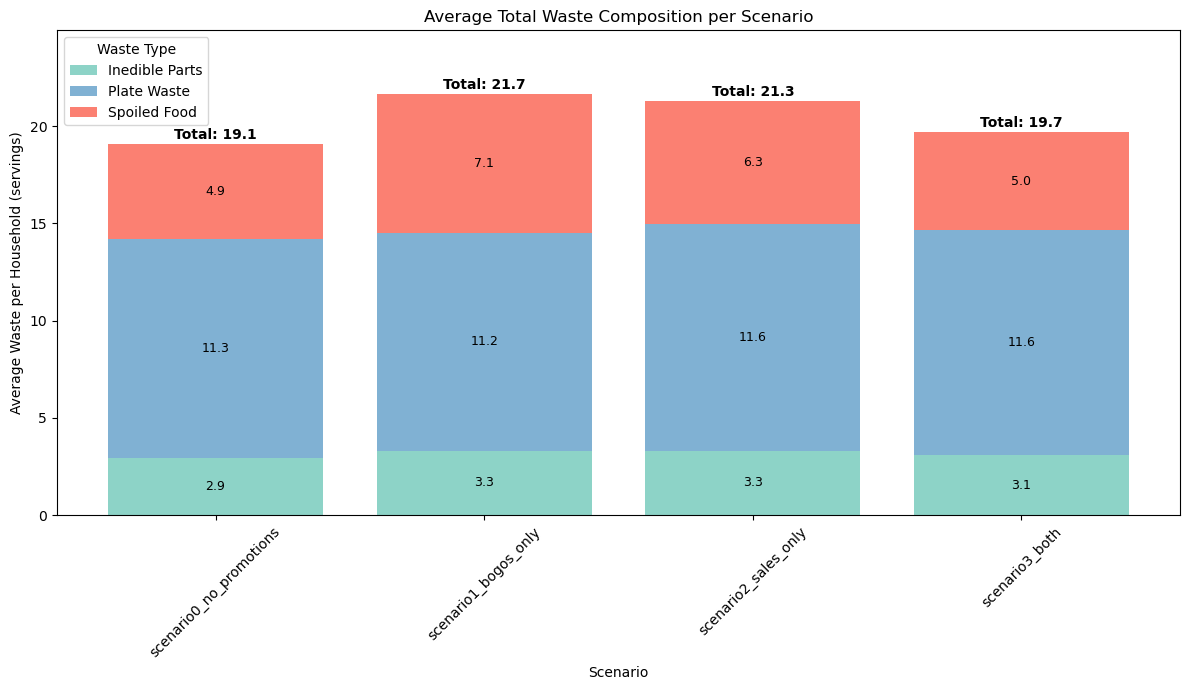

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Compute scenario averages ---
waste_summary = plot_df.groupby("scenario")[waste_columns].mean().reset_index()

# --- Step 2: Plot settings ---
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(waste_summary))

colors = {
    "Inedible Parts": "#8dd3c7",
    "Spoiled Food": "#fb8072",
    "Plate Waste": "#80b1d3"
}

x = np.arange(len(waste_summary["scenario"]))  # numeric x-positions for bars

# --- Step 3: Plot and annotate each segment ---
for waste_type in waste_columns:
    values = waste_summary[waste_type].values /100 #daily
    ax.bar(x, values, bottom=bottom, label=waste_type, color=colors.get(waste_type, None))

    # Annotate each segment
    for i in range(len(x)):
        y_center = bottom[i] + values[i] / 2
        if values[i] > 0.01:  # avoid cluttering with near-zero labels
            ax.text(x[i], y_center, f"{values[i]:.1f}", ha='center', va='center', fontsize=9, color='black')

    bottom += values

# --- Step 4: Add total value on top ---
total_waste = waste_summary[waste_columns].sum(axis=1).values
for i in range(len(x)):
    ax.text(x[i], bottom[i] + 0.1, f"Total: {total_waste[i]/100:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')#daily

# --- Step 5: Format plot ---
ax.set_title("Average Total Waste Composition per Scenario")
ax.set_xlabel("Scenario")
ax.set_ylabel("Average Waste per Household (servings)")
ax.set_xticks(x)
ax.set_xticklabels(waste_summary["scenario"], rotation=45)
ax.legend(title="Waste Type")
ax.set_ylim(0, max(bottom) * 1.15)  # Add room for top labels

plt.tight_layout()
plt.show()


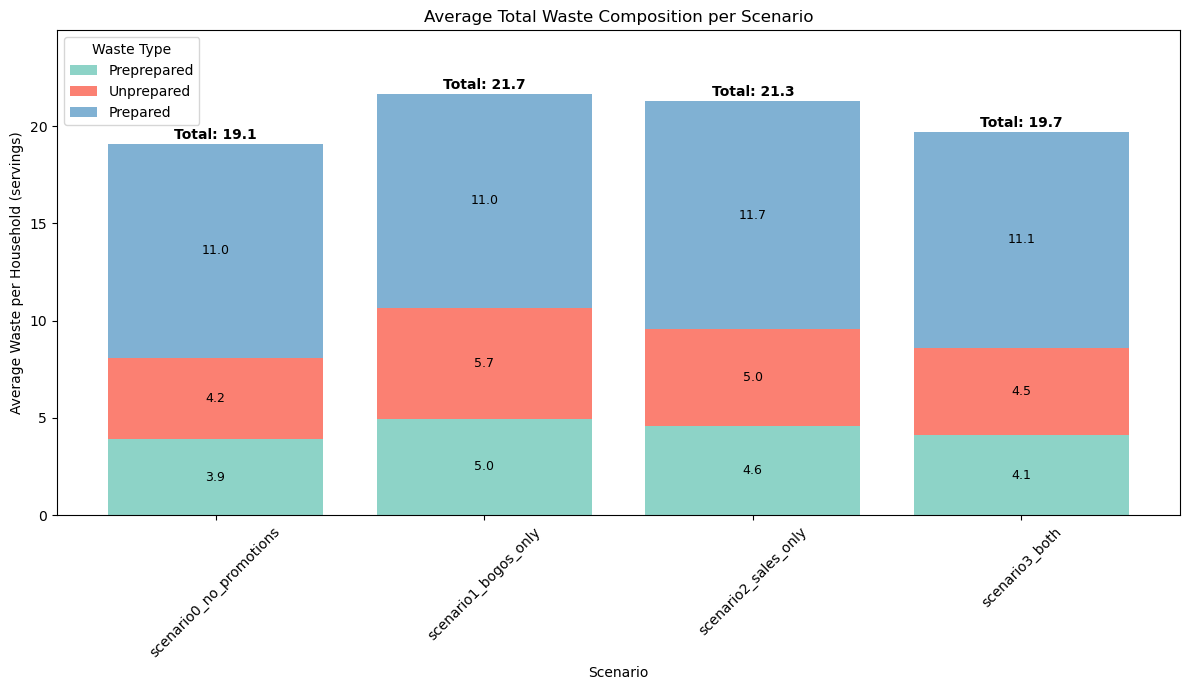

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Compute scenario averages ---
reason_col = ["Preprepared", "Unprepared", "Prepared"]
waste_summary = plot_df.groupby("scenario")[reason_col].mean().reset_index()

# --- Step 2: Plot settings ---
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(waste_summary))

colors = {
    "Preprepared": "#8dd3c7",
    "Unprepared": "#fb8072",
    "Prepared": "#80b1d3"
}

x = np.arange(len(waste_summary["scenario"]))  # numeric x-positions for bars

# --- Step 3: Plot and annotate each segment ---
for waste_type in reason_col:
    values = waste_summary[waste_type].values /100 #daily
    ax.bar(x, values, bottom=bottom, label=waste_type, color=colors.get(waste_type, None))

    # Annotate each segment
    for i in range(len(x)):
        y_center = bottom[i] + values[i] / 2
        if values[i] > 0.01:  # avoid cluttering with near-zero labels
            ax.text(x[i], y_center, f"{values[i]:.1f}", ha='center', va='center', fontsize=9, color='black')

    bottom += values

# --- Step 4: Add total value on top ---
total_waste = waste_summary[reason_col].sum(axis=1).values
for i in range(len(x)):
    ax.text(x[i], bottom[i] + 0.1, f"Total: {total_waste[i]/100:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')#daily

# --- Step 5: Format plot ---
ax.set_title("Average Total Waste Composition per Scenario")
ax.set_xlabel("Scenario")
ax.set_ylabel("Average Waste per Household (servings)")
ax.set_xticks(x)
ax.set_xticklabels(waste_summary["scenario"], rotation=45)
ax.legend(title="Waste Type")
ax.set_ylim(0, max(bottom) * 1.15)  # Add room for top labels

plt.tight_layout()
plt.show()


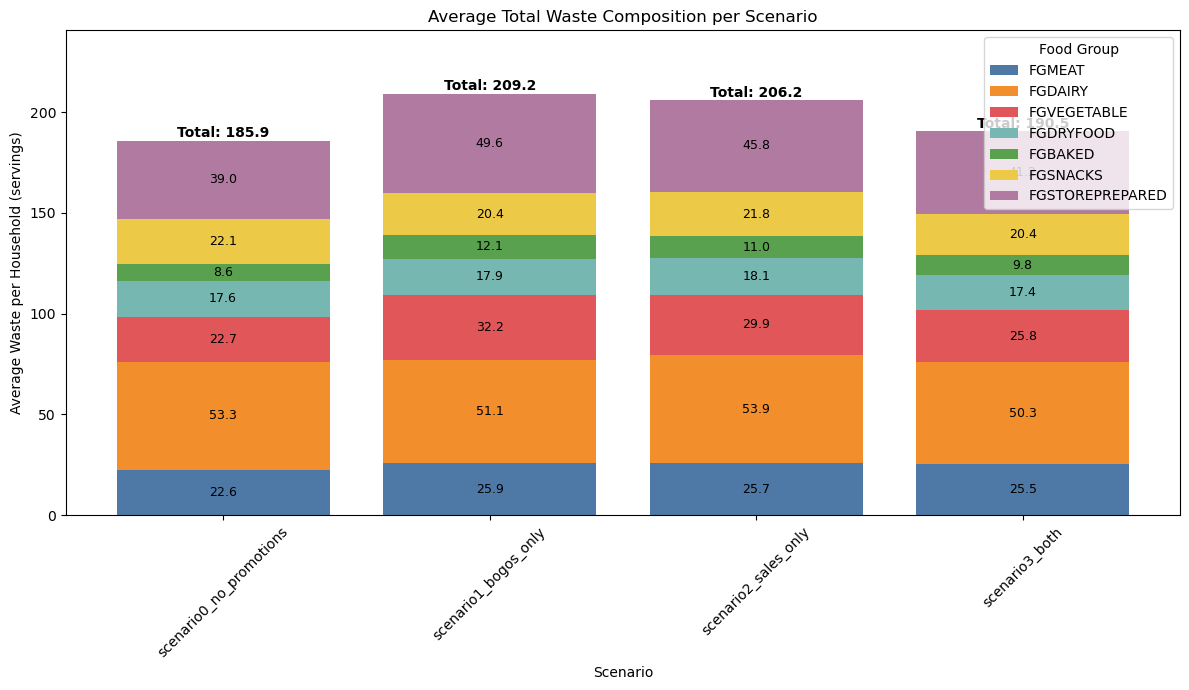

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fg_names = ["FGMEAT","FGDAIRY","FGVEGETABLE","FGDRYFOOD","FGBAKED","FGSNACKS","FGSTOREPREPARED"]

# --- Step 1: Compute scenario averages ---
waste_summary = plot_df.groupby("scenario")[fg_names].mean().reset_index()

# --- Step 2: Plot settings ---
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(waste_summary))

# Optional: define colors for each fg_name, or generate a colormap if you want
colors = {
    "FGMEAT": "#4E79A7",          # blue
    "FGDAIRY": "#F28E2B",         # orange
    "FGVEGETABLE": "#E15759",     # red
    "FGDRYFOOD": "#76B7B2",       # teal
    "FGBAKED": "#59A14F",         # green
    "FGSNACKS": "#EDC948",        # yellow
    "FGSTOREPREPARED": "#B07AA1"  # purple
}

x = np.arange(len(waste_summary["scenario"]))  # numeric x-positions for bars

# --- Step 3: Plot and annotate each segment ---
for fg in fg_names:
    values = waste_summary[fg].values  # daily average servings, no division by 100 unless your data needs scaling
    ax.bar(x, values, bottom=bottom, label=fg, color=colors.get(fg, None))

    # Annotate each segment
    for i in range(len(x)):
        y_center = bottom[i] + values[i] / 2
        if values[i] > 0.01:  # avoid cluttering with near-zero labels
            ax.text(x[i], y_center, f"{values[i]:.1f}", ha='center', va='center', fontsize=9, color='black')

    bottom += values

# --- Step 4: Add total value on top ---
total_waste = waste_summary[fg_names].sum(axis=1).values
for i in range(len(x)):
    ax.text(x[i], bottom[i] + 0.1, f"Total: {total_waste[i]:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Step 5: Format plot ---
ax.set_title("Average Total Waste Composition per Scenario")
ax.set_xlabel("Scenario")
ax.set_ylabel("Average Waste per Household (servings)")
ax.set_xticks(x)
ax.set_xticklabels(waste_summary["scenario"], rotation=45)
ax.legend(title="Food Group")
ax.set_ylim(0, max(bottom) * 1.15)  # Add room for top labels

plt.tight_layout()
plt.show()


In [7]:
## run all again but in kg 
# CONVERSION TO KG FOR FOOD GROUPS
for scenario in scenario_folders:
    wasted = scenario_data[scenario]
    wasted["Total_Kg"] = 0
    for food in fg_names:
        conversion_factor = lookup_df.loc[lookup_df["Fg_name"] == food, "Servings_to_kg"].values[0]
        wasted.loc[:, food] = wasted[food] * conversion_factor
        wasted["Total_Kg"] += wasted[food]
    
    


In [8]:
wasted

,household,required_servings,budget,adults,children,lvl_of_concern,plate_waste_ratio,avail_time_monday,avail_time_tuesday,avail_time_wednesday,...,Inedible Parts,Plate Waste,Spoiled Food,Prepared,Unprepared,Preprepared,run_household_key,Total_daily_servings,scenario,Total_Kg
0,0,49.612,1073.24,1,5,1.00,0.318,138,109,153,...,231.405,1879.043,114.734843,1483.282,242.681,499.221004,run_8_0,22.251828,scenario3_both,206.774430
1,1,52.286,1073.24,1,5,1.00,0.320,138,109,153,...,233.167,1917.298,45.671069,1537.246,259.631,399.259123,run_8_1,21.961361,scenario3_both,208.800487
2,2,52.925,1073.24,1,5,1.00,0.307,138,109,153,...,243.903,1609.012,51.858216,1334.995,241.782,327.996778,run_8_2,19.047732,scenario3_both,186.693080
3,3,52.925,1073.24,1,5,1.00,0.307,138,109,153,...,291.233,2310.988,223.373117,1773.174,455.971,596.448420,run_8_3,28.255941,scenario3_both,252.174482
4,4,55.599,1073.24,1,5,1.00,0.310,138,109,153,...,321.549,2421.214,121.652336,1880.731,378.447,605.236751,run_8_4,28.644153,scenario3_both,263.236265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,495,29.126,813.68,1,2,0.09,0.170,84,98,174,...,289.432,583.464,1009.753904,924.041,402.981,555.628016,run_1_495,18.826499,scenario3_both,193.099158
7996,496,32.981,813.68,1,2,0.09,0.160,84,98,174,...,289.373,618.030,726.664968,713.720,510.453,409.894883,run_1_496,16.340680,scenario3_both,161.247533
7997,497,27.547,813.68,1,2,0.09,0.168,84,98,174,...,165.477,504.500,395.899030,540.211,148.327,377.338051,run_1_497,10.658760,scenario3_both,110.076349
7998,498,31.403,813.68,1,2,0.09,0.157,84,98,174,...,310.698,572.356,868.359401,856.071,400.327,495.015558,run_1_498,17.514134,scenario3_both,178.068379


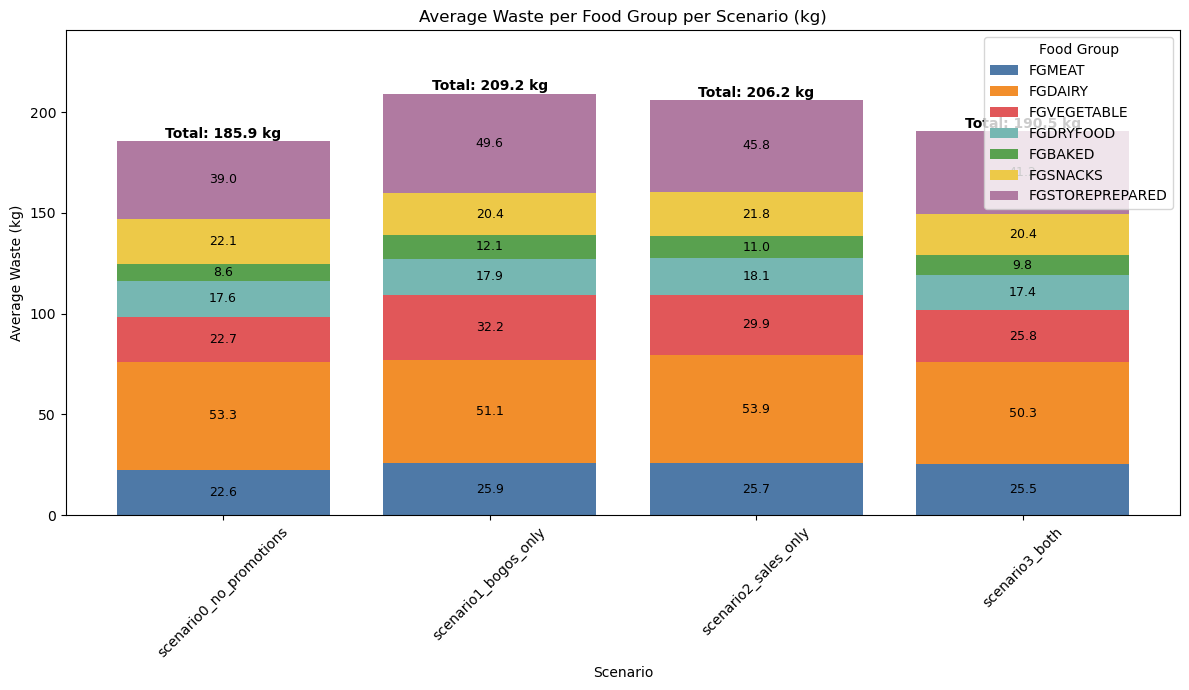

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine all scenarios into one DataFrame
plot_df = pd.concat(scenario_data.values(), ignore_index=True)

# Compute average per scenario for each food group (in kg)
waste_summary = plot_df.groupby("scenario")[fg_names].mean().reset_index()

# Plot settings
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(waste_summary))

colors = {
    "FGMEAT": "#4E79A7",
    "FGDAIRY": "#F28E2B",
    "FGVEGETABLE": "#E15759",
    "FGDRYFOOD": "#76B7B2",
    "FGBAKED": "#59A14F",
    "FGSNACKS": "#EDC948",
    "FGSTOREPREPARED": "#B07AA1"
}

x = np.arange(len(waste_summary["scenario"]))

for fg in fg_names:
    values = waste_summary[fg].values
    ax.bar(x, values, bottom=bottom, label=fg, color=colors.get(fg, "#333333"))
    
    # Annotate each segment's value in the middle of the bar segment
    for i in range(len(x)):
        if values[i] > 0.01:  # avoid cluttering with near-zero values
            y = bottom[i] + values[i] / 2
            ax.text(x[i], y, f"{values[i]:.1f}", ha='center', va='center', fontsize=9, color='black')
    
    bottom += values

# Add total value labels on top (removed division by 100, assuming data already in kg)
total_waste = waste_summary[fg_names].sum(axis=1).values
for i in range(len(x)):
    ax.text(x[i], bottom[i] + 0.05, f"Total: {total_waste[i]:.1f} kg", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Format plot
ax.set_title("Average Waste per Food Group per Scenario (kg)")
ax.set_xlabel("Scenario")
ax.set_ylabel("Average Waste (kg)")
ax.set_xticks(x)
ax.set_xticklabels(waste_summary["scenario"], rotation=45)
ax.legend(title="Food Group")
ax.set_ylim(0, max(bottom) * 1.15)

plt.tight_layout()
plt.show()


/scratch/local/10041665/ipykernel_3095894/3009653910.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="scenario", y="Total_Kg", palette="Set2")
/scratch/local/10041665/ipykernel_3095894/3009653910.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=mean_waste, x="scenario", y="Total_Kg", palette="Set2")


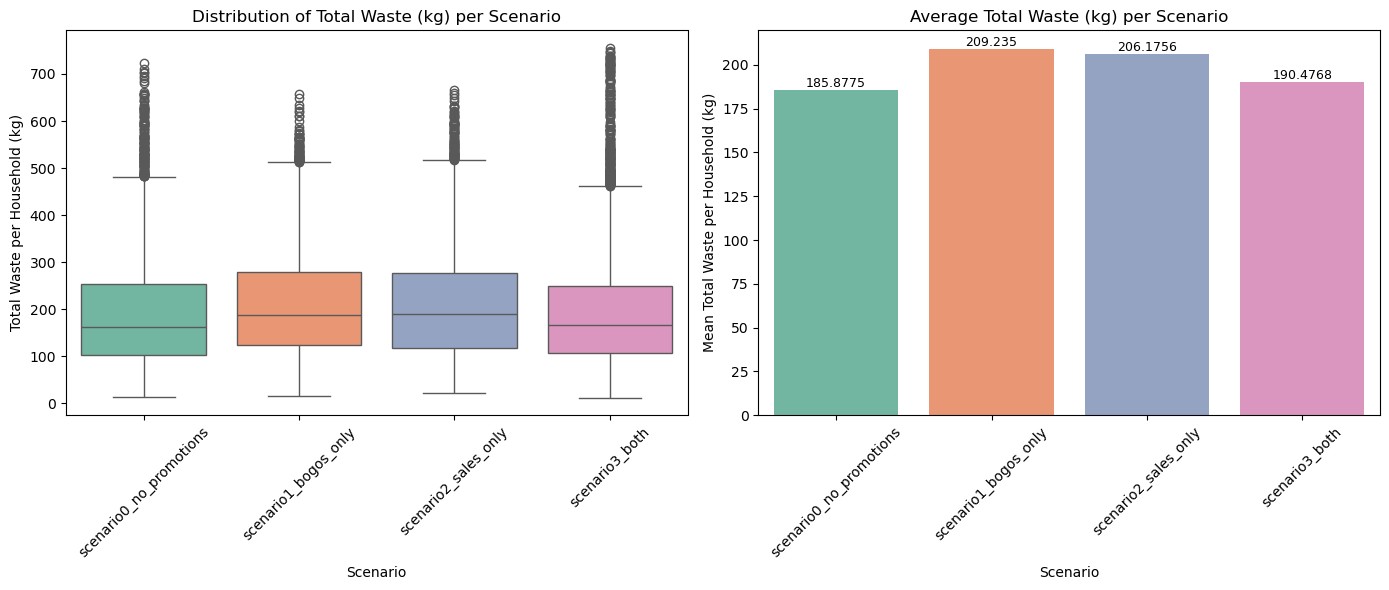

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all scenarios into one DataFrame for plotting
plot_df = pd.concat(scenario_data.values(), ignore_index=True)

plt.figure(figsize=(14, 6))

# --- Boxplot ---
plt.subplot(1, 2, 1)
sns.boxplot(data=plot_df, x="scenario", y="Total_Kg", palette="Set2")
plt.title("Distribution of Total Waste (kg) per Scenario")
plt.xlabel("Scenario")
plt.ylabel("Total Waste per Household (kg)")
plt.xticks(rotation=45)

# --- Barplot (Mean) ---
plt.subplot(1, 2, 2)
mean_waste = plot_df.groupby("scenario")["Total_Kg"].mean().reset_index()
bars = sns.barplot(data=mean_waste, x="scenario", y="Total_Kg", palette="Set2")
for bar in bars.patches:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=9)

plt.title("Average Total Waste (kg) per Scenario")
plt.xlabel("Scenario")
plt.ylabel("Mean Total Waste per Household (kg)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
